<a href="https://colab.research.google.com/github/shoutingraven369/credit_card_fraud_detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost  import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report ,roc_auc_score ,roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
import joblib


In [2]:
df=pd.read_csv('creditcard.csv')

In [17]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.199177,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.223085,0.0
1,-2.199177,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.357062,0.0
2,-2.199100,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.127440,0.0
3,-2.199100,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.119951,0.0
4,-2.199024,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.091331,0.0


In [4]:
df.dropna(inplace=True)

In [5]:
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df['Time'] = StandardScaler().fit_transform(df[['Time']])

In [6]:
x =df.drop('Class',axis=1)
y= df['Class']

In [7]:
X_train,  X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

In [8]:
iso_model = IsolationForest(contamination=0.0017, random_state=42)
iso_model.fit(X_train)

iso_preds = iso_model.predict(X_test)

In [9]:
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
XGB = XGBClassifier(scale_pos_weight=scale_pos_weight ,Use_label_encoder= False , eval_metric= 'logloss')
XGB.fit(X_res,y_res)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:50:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "Use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(Use_label_encoder=False, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
y_pred = XGB.predict(X_test)

In [11]:
final_preds = []

for iso, xgb in zip(iso_preds, y_pred):
    if (iso == -1) or (xgb == 1):
        final_preds.append(1)
    else:
        final_preds.append(0)

In [12]:

y_proba =   XGB.predict_proba(X_test)[:, 1]
print(confusion_matrix(y_test, final_preds))

print('CLASSIFICATION \n',classification_report(y_test, final_preds))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[[9878   11]
 [   0   33]]
CLASSIFICATION 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9889
         1.0       0.75      1.00      0.86        33

    accuracy                           1.00      9922
   macro avg       0.88      1.00      0.93      9922
weighted avg       1.00      1.00      1.00      9922

ROC AUC: 0.9999172634423923


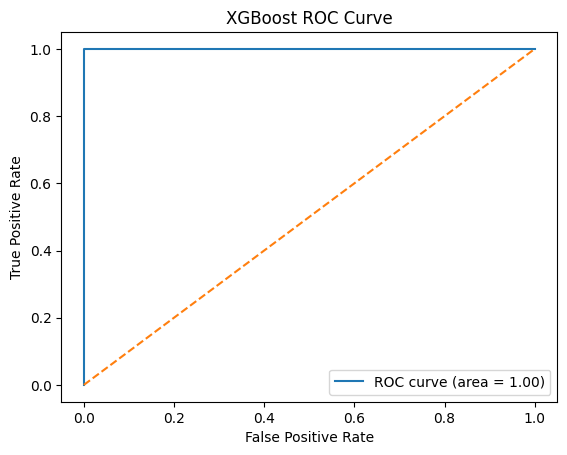

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
joblib.dump(XGB,'xgb_model.pkl')
joblib.dump(iso_model, "iso_model.pkl")

['iso_model.pkl']